In [1]:
import os
import sys
from pathlib import Path
BACKTESTER_DIR = Path(".").resolve().parent.parent

DATA_DIR = BACKTESTER_DIR / '../mori_opt_earnings/data/interim/optm_lz/opprcd'
print(DATA_DIR)
OPTIONS_DATA = os.path.join(DATA_DIR, 'SPX_2017.csv')
STOCKS_DATA = os.path.join(DATA_DIR, 'portfolio_data_2017.csv')
sys.path.append(BACKTESTER_DIR) # Add backtester base dir to $PYTHONPATH

/media/wassname/SGIronWolf/projects5/investing/options/options_backtester/../mori_opt_earnings/data/interim/optm_lz/opprcd


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pyfolio as pf
import matplotlib.pyplot as plt

from backtester import Backtest
from backtester.strategy import Strategy, StrategyLeg
from backtester.enums import Type, Direction, Stock
from backtester.datahandler import HistoricalOptionsData, TiingoData, Schema, OptionMetricsData
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

As an example, we run a 2017 backtest of a portfolio consisting of a 97% allocation in stocks and 3% in options. The backtest will run for the time period spanned by the data, performing periodic rebalances with a user given frequency. 

Stock data is taken from [Tiingo](https://api.tiingo.com).

In [5]:
# %env TIINGO_API_KEY=your_tiingo_api_key
from dotenv import load_dotenv
import os
load_dotenv()

True

# Data

## get_data_tiingo

In [6]:
import datetime
import pandas_datareader as pdr
# restricting to 1996-01-04 00:00:00 2019-06-28 00:00:00
api_key = os.environ["TIINGO_API_KEY"]
start = datetime.datetime(1996, 1, 4)
end = datetime.datetime(2019, 6, 28)
tickers = ["MSFT", "AAPL", "XOM"] #, "TUR", "RSX", "EWY", "EWS", "VTIP", "TLT", "BWX", "PDBC", "IAU", "VNQI"]

symbols = pdr.get_data_tiingo(tickers, api_key=api_key, start=start, end=end)
symbols

/home/wassname/miniforge3/envs/mori_opt_earnings/lib/python3.7/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


close   high    low   open    volume  \
symbol date                                                              
MSFT   1996-01-04 00:00:00+00:00  87.37  87.50  84.87  87.25   6397100   
       1996-01-05 00:00:00+00:00  86.37  87.62  86.12  86.25   3880200   
       1996-01-08 00:00:00+00:00  86.25  87.62  86.12  86.50    711100   
       1996-01-09 00:00:00+00:00  80.19  86.00  79.87  86.00  11089000   
       1996-01-10 00:00:00+00:00  82.37  83.25  80.48  80.50  11348200   
...                                 ...    ...    ...    ...       ...   
XOM    2019-06-24 00:00:00+00:00  76.95  77.76  76.81  77.53  10012236   
       2019-06-25 00:00:00+00:00  76.27  77.22  76.19  77.08   9739970   
       2019-06-26 00:00:00+00:00  76.60  77.13  76.47  76.68  11365476   
       2019-06-27 00:00:00+00:00  75.82  76.75  75.76  76.59   8147803   
       2019-06-28 00:00:00+00:00  76.63  76.73  75.94  76.19  14781298   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
MSFT   1996-01-04 00:00:00+00:00   3.439386   3.444504   3.340972   3.434662   
       1996-01-05 00:00:00+00:00   3.400020   3.449227   3.390179   3.395296   
       1996-01-08 00:00:00+00:00   3.395296   3.449227   3.390179   3.405138   
       1996-01-09 00:00:00+00:00   3.156740   3.385455   3.144143   3.385455   
       1996-01-10 00:00:00+00:00   3.242557   3.277199   3.168156   3.168943   
...                                     ...        ...        ...        ...   
XOM    2019-06-24 00:00:00+00:00  64.097147  64.771854  63.980531  64.580270   
       2019-06-25 00:00:00+00:00  63.530727  64.322049  63.464089  64.205433   
       2019-06-26 00:00:00+00:00  63.805607  64.247082  63.697321  63.872245   
       2019-06-27 00:00:00+00:00  63.155889  63.930553  63.105911  63.797277   
       2019-06-28 00:00:00+00:00  63.830596  63.913893  63.255846  63.464089   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
MSFT   1996-01-04 00:00:00+00:00  102353600      0.0          1.0  
       1996-01-05 00:00:00+00:00   62083200      0.0          1.0  
       1996-01-08 00:00:00+00:00   11377600      0.0          1.0  
       1996-01-09 00:00:00+00:00  177424000      0.0          1.0  
       1996-01-10 00:00:00+00:00  181571200      0.0          1.0  
...                                     ...      ...          ...  
XOM    2019-06-24 00:00:00+00:00   10012236      0.0          1.0  
       2019-06-25 00:00:00+00:00    9739970      0.0          1.0  
       2019-06-26 00:00:00+00:00   11365476      0.0          1.0  
       2019-06-27 00:00:00+00:00    8147803      0.0          1.0  
       2019-06-28 00:00:00+00:00   14781298      0.0          1.0  

[17736 rows x 12 columns]

In [7]:
save_path = os.path.join(DATA_DIR, 'portfolio_data_2017.csv')
symbols.to_csv(save_path)

Use *TiingoData* to load your stocks csv. Data must include `date`, `adjClose` and `symbol` columns to work.

In [8]:
stock_data = TiingoData(STOCKS_DATA)
# remove tz
stock_data['date']=stock_data['date'].dt.tz_localize(None)
stock_data.start_date=stock_data.start_date.tz_localize(None)
stock_data.end_date=stock_data.end_date.tz_localize(None)
stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,1996-01-04,87.37,87.50,84.87,87.25,6397100,3.439386,3.444504,3.340972,3.434662,102353600,0.0,1.0
1,MSFT,1996-01-05,86.37,87.62,86.12,86.25,3880200,3.400020,3.449227,3.390179,3.395296,62083200,0.0,1.0
2,MSFT,1996-01-08,86.25,87.62,86.12,86.50,711100,3.395296,3.449227,3.390179,3.405138,11377600,0.0,1.0
3,MSFT,1996-01-09,80.19,86.00,79.87,86.00,11089000,3.156740,3.385455,3.144143,3.385455,177424000,0.0,1.0
4,MSFT,1996-01-10,82.37,83.25,80.48,80.50,11348200,3.242557,3.277199,3.168156,3.168943,181571200,0.0,1.0


To create a stock portfolio, use `Stock` as Stock(*name*, *percentage*), where *name* should match the name given in the `symbol` column and *percentage* is the percentage (from 0 to 1) allocated to that specific asset. Afterwards, store them in a list.

In [9]:
MSFT = Stock('MSFT', 0.3)
AAPL = Stock('AAPL', 0.3)
XOM = Stock('XOM', 0.4)
# EWY = Stock('EWY', 0.05)
# EWS = Stock('EWS', 0.05)
# VTIP = Stock('VTIP', 0.10)
# TLT = Stock('TLT', 0.20)
# BWX = Stock('BWX', 0.10)
# PDBC = Stock('PDBC', 0.05)
# IAU = Stock('IAU', 0.15)
# VNQI = Stock('VNQI', 0.10)

Make sure the sum of the percentages is 1.

In [10]:
0.10 + 0.05 + 0.05 + 0.05 + 0.05 + 0.10 + 0.20 + 0.10 + 0.05 + 0.15 + 0.10

1.0000000000000002

In [11]:
stocks = [
    MSFT,
    AAPL,
    XOM,
    # EWY,
    # EWS,
    # VTIP,
    # TLT,
    # BWX,
    # PDBC,
    # IAU,
    # VNQI
]

## Options

To load your options data, use `HistoricalOptionsData`. Both this and `Stock` make use of an underlying `schema` to map the expected column names to the ones in your data. *Schema.stocks()* and *Schema.options()* will return the default mappings (i.e, the ones that don't change anything). If you need to change some values in them use *update* like so:

In [12]:
options_schema = Schema.options()
options_schema.update({
    'underlying': 'stock',
            'contract': 'optionroot',
            'date': 'quotedate'})
options_schema

Schema([Field(name='underlying', mapping='stock'), Field(name='underlying_last', mapping='underlying_last'), Field(name='date', mapping='quotedate'), Field(name='contract', mapping='optionroot'), Field(name='type', mapping='type'), Field(name='expiration', mapping='expiration'), Field(name='strike', mapping='strike'), Field(name='bid', mapping='bid'), Field(name='ask', mapping='ask'), Field(name='volume', mapping='volume'), Field(name='open_interest', mapping='open_interest')])

In the last cell we updated the schema so that the *contract* and *date* columns are mapped to *optionroot* and *quotedate*, as they are in our data. This isn't needed in our case, since the default schema used by the backtester already uses this mapping; in general though, to use a custom schema pass it to `Stock` or `HistoricalOptionsData` when loading the csv (*schema=None* uses the default schema).

In [13]:
options_data = OptionMetricsData(["MSFT", "AAPL", "XOM"], schema=None)
schema = options_data.schema
options_data.head()

,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,secid,ticker,dte
0,1996-01-04,09D05.1F,0,1996-01-20,NaT,P,55000.0,0.000,0.0625,0.0,...,0.0,100.0,0,87.580727,,09D05,1F,107525.0,MSFT,16
1,1996-01-04,09907.E9,0,1996-02-17,1996-01-04,C,80000.0,9.375,9.7500,2.0,...,0.0,100.0,0,87.960975,,09907,E9,107525.0,MSFT,44
2,1996-01-04,09E5B.96,0,1996-07-20,1996-01-04,C,80000.0,14.250,14.7500,1.0,...,0.0,100.0,0,89.972692,,09E5B,96,107525.0,MSFT,198
3,1996-01-04,09D7E.EF,0,1997-01-18,NaT,P,70000.0,3.125,3.5000,0.0,...,0.0,100.0,0,92.275048,,09D7E,EF,107525.0,MSFT,380
4,1996-01-04,09EF9.89,0,1996-04-20,1996-01-04,C,90000.0,6.500,6.8750,135.0,...,0.0,100.0,0,88.796785,,09EF9,89,107525.0,MSFT,107


In [14]:
options_data.ticker.unique()

array(['MSFT', 'AAPL', 'XOM'], dtype=object)

In [15]:
# d0 = max(options_data['date'].min(), stock_data['date'].min())
# d1 = min(options_data['date'].max(), stock_data['date'].max())
# print("restricting to", d0, d1)
# stock_data = stock_data[(stock_data.date <= d1) & (stock_data.date >= d0)]
date_col = stock_data.schema['date']
stock_data.start_date = stock_data._data[date_col].min()
stock_data.end_date = stock_data._data[date_col].max()
# # remove tz
# stock_data['date']=stock_data.date.dt.tz_localize(None)
# stock_data.head()
# # options_data._data = options_data_data[(options_data.date <= d1) & (options_data.date >= d0)]

# Strat

For the options part of the backtest, we create a `Strategy` to determine when to enter on certain contracts. Remember to pass the options schema when creating it.

In [16]:
long_straddle = Strategy(schema)

Each strategy consists of one or more legs created with `StrategyLeg`. A leg consists of a type of contract (*put* or *call*) and a direction to enter (*buy* or *sell*). Our long straddle will have two legs, which will buy a call and a put respectively.

In [17]:
leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)

Legs have entry and exit filters, to determine the conditions a contract from that leg has to satisfy to select it for entry/exit. Filters are created with the following syntax, using the options schema to refer to column names (such as `underlying`, `dte` or `strike`).

In [18]:
# options_data.head()

In [19]:
leg1.entry_filter = (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)
leg2.entry_filter = (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 60)
leg2.exit_filter = (schema.dte <= 60)

long_straddle.add_legs([leg1, leg2]);

In [20]:
# leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)
# leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

# leg1.exit_filter = (schema.dte <= 60)
# leg2.exit_filter = (schema.dte <= 60)

# long_straddle.add_legs([leg1, leg2]);

In this case, the first leg will look for contracts with *SPX* as the underlying which have between 31 and 60 days to expiration (*dte*) and are at the money (*ATM*), i.e, their strike price is close to their spot. After entering, the exit filter will exit contracts having 60 or less *dte*, which for this given strategy means we will always exit contracts. This effectively means we are buying ATM put and call contracts, keeping them for a month and then selling them.

In [21]:
stocks

[Stock(symbol='MSFT', percentage=0.3),
 Stock(symbol='AAPL', percentage=0.3),
 Stock(symbol='XOM', percentage=0.4)]

# Run

To put it all together, create a `Backtest` object and pass it a map specifying the percentage allocated to stocks, options and cash. Then set the stock portfolio, the options strategy and the data and run it.

In [41]:
bt = Backtest({'stocks': 0.5, 'options': 0.5, 'cash': 0})
bt.stocks = stocks
bt.options_strategy = long_straddle
bt.options_data = options_data
bt.stocks_data = stock_data

In [42]:
options_data['date'].unique()

array(['1996-01-04T00:00:00.000000000', '1996-01-05T00:00:00.000000000',
       '1996-01-08T00:00:00.000000000', ...,
       '2019-06-26T00:00:00.000000000', '2019-06-27T00:00:00.000000000',
       '2019-06-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [43]:
stock_data['date'].unique()
stock_data.start_date

Timestamp('1996-01-04 00:00:00')

The *run* method takes the initial capital (default value *1.000.000*) and `rebalance_freq` as arguments. This last one defines how often, in months, a rebalancing of the portfolio is made, so that a value of 1 means a monthly rebalancing and 6 a bi-annual one. Its value defaults to 0, meaning no rebalancing done.

In [44]:
bt.run(rebalance_freq=1)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31


Empty DataFrame
Columns: [(leg_1, contract), (leg_1, underlying), (leg_1, expiration), (leg_1, type), (leg_1, strike), (leg_1, cost), (leg_1, order), (leg_2, contract), (leg_2, underlying), (leg_2, expiration), (leg_2, type), (leg_2, strike), (leg_2, cost), (leg_2, order), (totals, cost), (totals, qty), (totals, date)]
Index: []

When done, the backtester returns a trade log with all the option trades. There is also a balance sheet with daily returns, capital and other information for each stock symbol and options.

In [45]:
bt.balance

,total capital,cash,MSFT,AAPL,XOM,options qty,calls capital,puts capital,stocks qty,MSFT qty,AAPL qty,XOM qty,options capital,stocks capital,% change,accumulated return
1996-01-03,1.000000e+06,1.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,NaN,NaN
1996-01-04,1.000000e+06,5.000041e+05,1.499985e+05,1.499999e+05,1.999975e+05,0.0,0.0,0.0,688386.0,43612.0,622655.0,22119.0,0.0,4.999959e+05,0.000000,1.000000
1996-01-05,1.015984e+06,5.000041e+05,1.482817e+05,1.627850e+05,2.049133e+05,0.0,0.0,0.0,688386.0,43612.0,622655.0,22119.0,0.0,5.159800e+05,0.015984,1.015984
1996-01-08,1.020042e+06,5.000041e+05,1.480757e+05,1.645911e+05,2.073712e+05,0.0,0.0,0.0,688386.0,43612.0,622655.0,22119.0,0.0,5.200379e+05,0.003994,1.020042
1996-01-09,9.967210e+05,5.000041e+05,1.376717e+05,1.556558e+05,2.033894e+05,0.0,0.0,0.0,688386.0,43612.0,622655.0,22119.0,0.0,4.967169e+05,-0.022863,0.996721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-21,8.976873e+06,4.235908e+06,1.452253e+06,1.457513e+06,1.831199e+06,0.0,0.0,0.0,69275.0,10928.0,30050.0,28297.0,0.0,4.740965e+06,0.002309,8.976873
2019-06-24,8.966552e+06,4.235908e+06,1.460841e+06,1.456047e+06,1.813757e+06,0.0,0.0,0.0,69275.0,10928.0,30050.0,28297.0,0.0,4.730644e+06,-0.001150,8.966552
2019-06-25,8.882332e+06,4.235908e+06,1.414719e+06,1.433976e+06,1.797729e+06,0.0,0.0,0.0,69275.0,10928.0,30050.0,28297.0,0.0,4.646424e+06,-0.009393,8.882332
2019-06-26,8.926428e+06,4.235908e+06,1.420020e+06,1.464992e+06,1.805507e+06,0.0,0.0,0.0,69275.0,10928.0,30050.0,28297.0,0.0,4.690520e+06,0.004964,8.926428


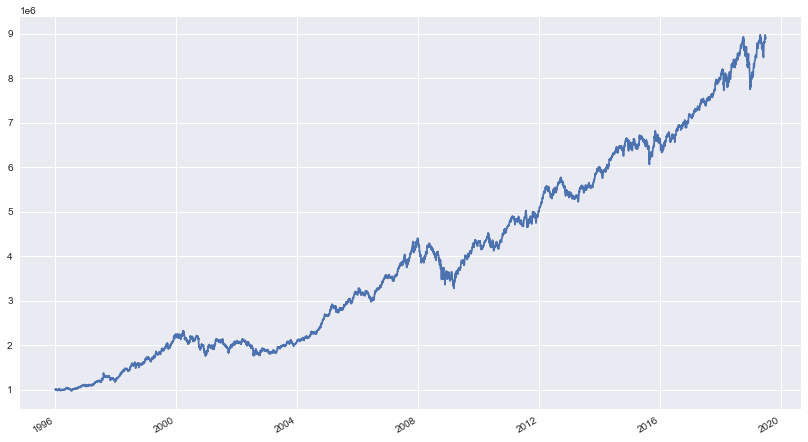

In [46]:
bt.balance['total capital'].plot();

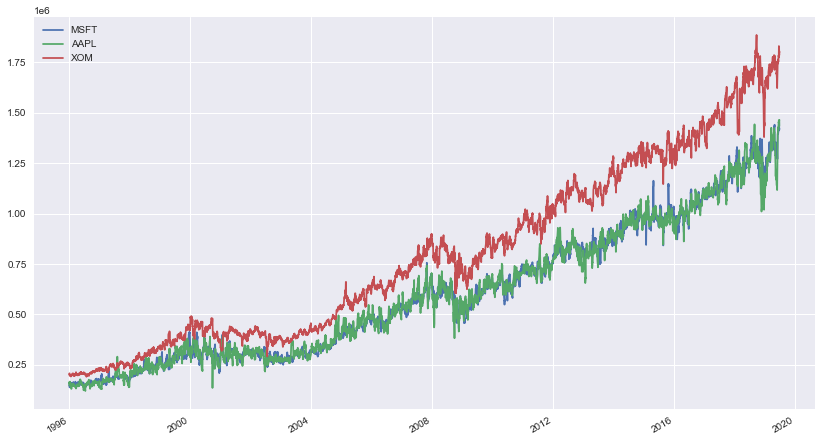

In [47]:
bt.balance[[stock.symbol for stock in stocks]].plot();

Pass the balance dataframe to 
the functions `returns_chart`, `returns_histogram` and `monthly_returns_heatmap` for better visualization. 

In [48]:
returns_chart(bt.balance)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.VConcatChart(...)

In [49]:
monthly_returns_heatmap(bt.balance)

alt.Chart(...)

In [50]:
returns_histogram(bt.balance)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

The backtest also supports an [sma](https://www.investopedia.com/terms/s/sma.asp) option. If the argument `sma_days` is passed to the `run` method with a value of n, on each rebalancing day the backtest will only buy shares of a stock symbol if its current price is above the sma of the last n days. To illustrate, we run the same backtest as before but with *sma_days = 30*.

In [51]:
bt.run(rebalance_freq=1, sma_days=30);

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


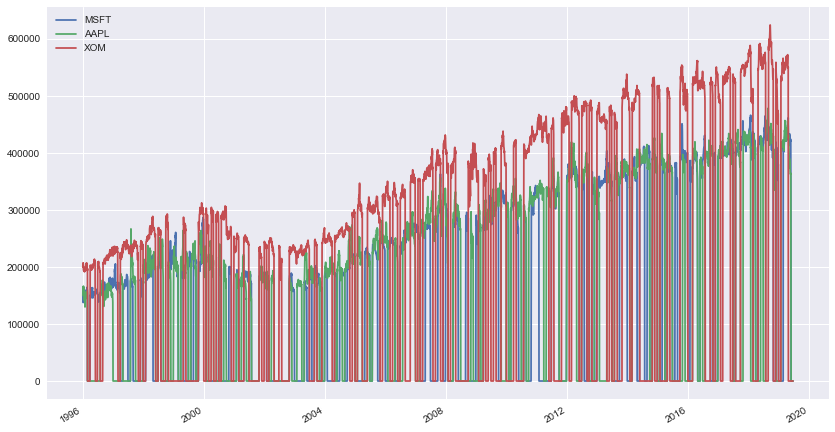

In [52]:
bt.balance[[stock.symbol for stock in stocks]].plot();

Notice how the capital held in certain symbols sometimes drops to zero, meaning on those months we did not buy shares of those symbols because their price was below the sma.

Finally, the daily returns column (`% change`) can be passed to the Quantopian library [pyfolio](https://github.com/quantopian/pyfolio) to obtain summary statistics and a few plots of the returns.

In [53]:
pf.create_returns_tear_sheet(returns =  bt.balance['% change'].dropna())

/home/wassname/miniforge3/envs/mori_opt_earnings/lib/python3.7/site-packages/empyrical/utils.py:442: UserWarning: Yahoo Finance read failed: 'date', falling back to Google
  UserWarning)


AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'